# IEEE Fraud Detection Kaggle Competition
## LightGBM TransactionDT feature engineering

In [1]:
%%bash

ls -l

echo ''

cd ../data

ls -l

echo ''

cd ../output

ls -l

total 16456
-rw-r--r--  1 cchadha2  749149485  1976809 Aug  9 10:16 EDA.ipynb
-rw-r--r--  1 cchadha2  749149485  1661687 Jul 29 22:42 IDs-EDA.ipynb
-rw-r--r--  1 cchadha2  749149485   222386 Aug  8 22:25 adverserial_validation.ipynb
-rw-r--r--  1 cchadha2  749149485  2298769 Aug  9 10:16 lgb_transactionDT.ipynb
-rw-r--r--  1 cchadha2  749149485   237097 Aug  7 15:28 lightgbm_baseline.ipynb
-rw-r--r--  1 cchadha2  749149485   335980 Aug  9 10:15 lightgbm_card1_count_encoded.ipynb
-rw-r--r--  1 cchadha2  749149485   230960 Aug  8 22:25 lightgbm_card1_count_encoded_20kval.ipynb
-rw-r--r--  1 cchadha2  749149485   867988 Jul 30 18:23 log_reg.ipynb
-rw-r--r--  1 cchadha2  749149485   573592 Aug  7 22:19 val_indices_>0.5.npy

total 220088
-rw-r--r--  1 cchadha2  749149485   1193102 Jul 16 17:16 sample_submission.csv.zip
-rw-r--r--  1 cchadha2  749149485   3114671 Jul 16 17:16 test_identity.csv.zip
-rw-r--r--  1 cchadha2  749149485  49628952 Jul 16 17:16 test_transaction.csv.zip
-rw-r--r--  1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

/Users/cchadha2/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

num_folds = 5
SEED = 5000

# Load and prepare data

In [3]:
train = pd.read_csv('../output/train_card1_count.csv')
test = pd.read_csv('../output/test_card1_count.csv')
sub_df = pd.read_csv('../data/sample_submission.csv.zip')

In [4]:
val_indices = np.load('../output/val_indices.npy')

In [5]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card1_count
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.

In [6]:
print(train.shape)

(590540, 435)


In [7]:
print(test.shape)

(506691, 434)


In [8]:
# Lightgbm parameters from https://www.kaggle.com/vincentlugat/ieee-lgb-bayesian-opt
params = {
        'bagging_fraction': 0.8999999999997461,
        'feature_fraction': 0.8999999999999121,
        'max_depth': int(50.0),
        'min_child_weight': 0.0029805017044362268,
        'min_data_in_leaf': int(20.0),
        'num_leaves': int(381.85354295079446),
        'reg_alpha': 1.0,
        'reg_lambda': 2.0,
        'objective': 'binary',
        'save_binary': True,
        'seed': SEED,
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

early_rounds = 50
num_iterations = 200

In [9]:
categorical_features=['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                      'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
                      'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                      'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15',
                      'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
                      'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
                      'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
                      'id_37', 'id_38']

In [10]:
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

# TransactionDT

Are the validation indices quite close to the Transaction DT of test?

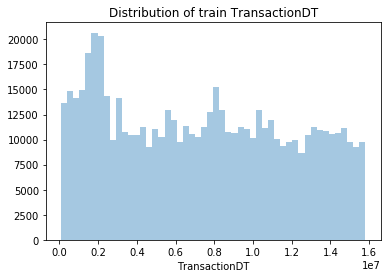

In [11]:
plt.figure()
sns.distplot(train.iloc[:, 2], kde=False)
plt.title('Distribution of train TransactionDT')
plt.show()

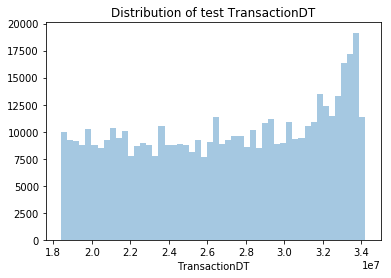

In [12]:
plt.figure()
sns.distplot(test.iloc[:, 1], kde=False)
plt.title('Distribution of test TransactionDT')
plt.show()

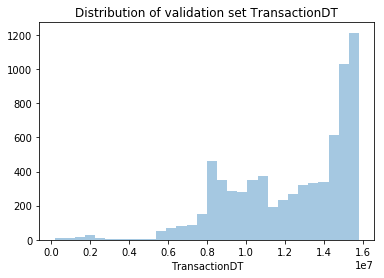

In [13]:
plt.figure()
sns.distplot(train.iloc[val_indices, 2], kde=False)
plt.title('Distribution of validation set TransactionDT')
plt.show()

Definitely a lot more samples closer to the TransactionDT of the test set that were considered most similar to test. Interesting to see some spikes in the middle where there are two smaller spikes of samples that were seen as being similar to the test set by our adv. val. LGB model. Also peaks at the start of train and end of test.

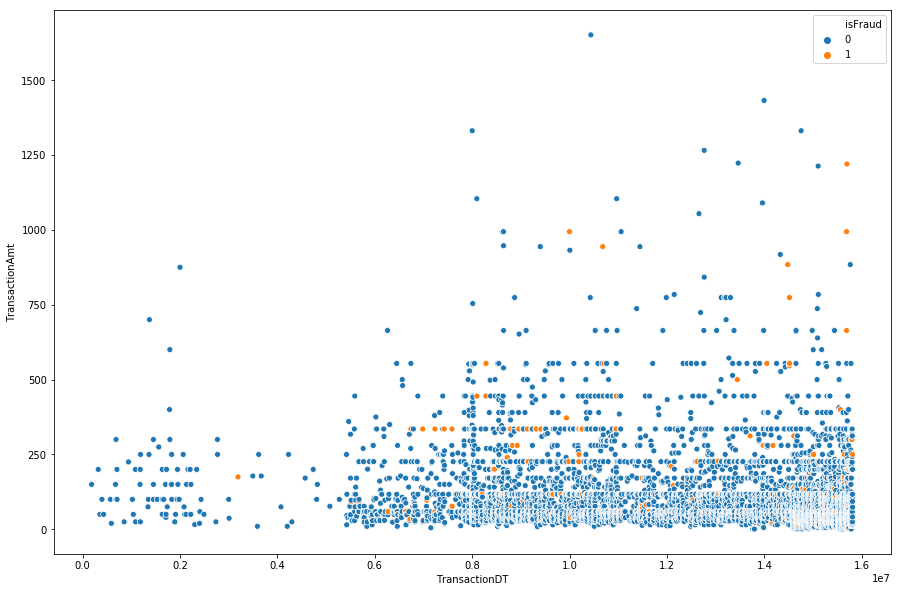

In [14]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='TransactionDT', y='TransactionAmt', hue='isFraud', data=train.iloc[val_indices, :])
plt.show()

Encoding TransactionDT into days of the week by fitting each delta into a category from 1-7. addr2 may be a country code and if so, the timezone would be the same for a large number of these transactions so encoding the time delta to fit into a day of the week and time of day may aid in prediction of fraud

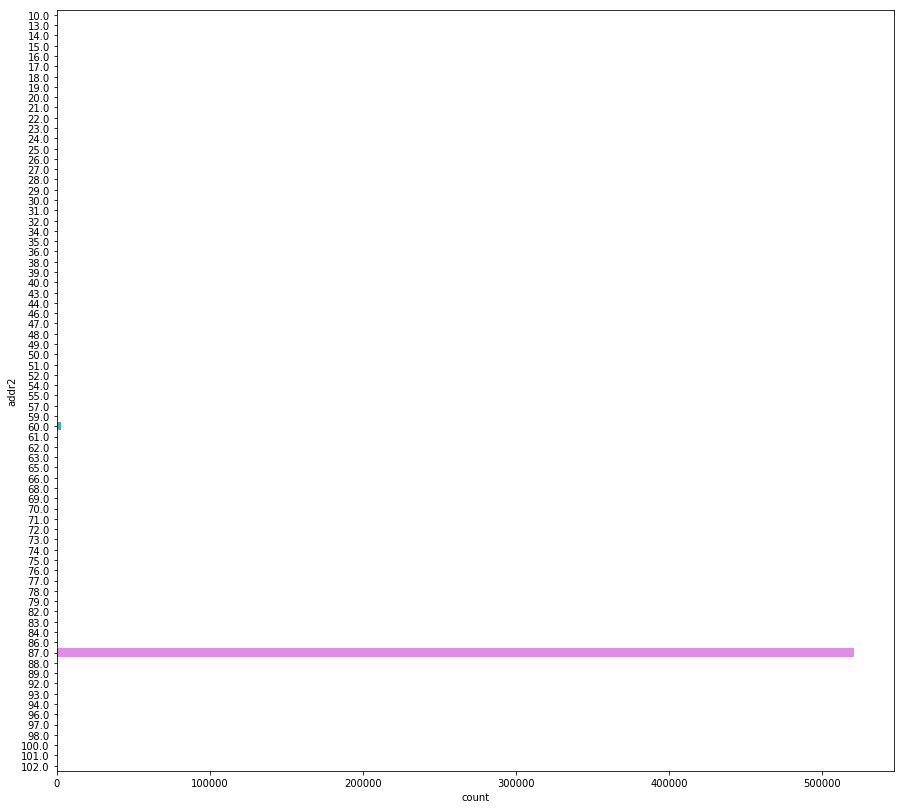

In [15]:
plt.figure(figsize=(15,14))
sns.countplot(y = train['addr2'])
plt.show()

Convert seconds into days

In [16]:
days = train['TransactionDT'] / (60*60*24)

In [17]:
days.head()

0    1.000000
1    1.000012
2    1.000799
3    1.001146
4    1.001227
Name: TransactionDT, dtype: float64

In [18]:
days.tail()

590535    182.998229
590536    182.998252
590537    182.998600
590538    182.998704
590539    182.999201
Name: TransactionDT, dtype: float64

In [19]:
days_of_week = days % 7

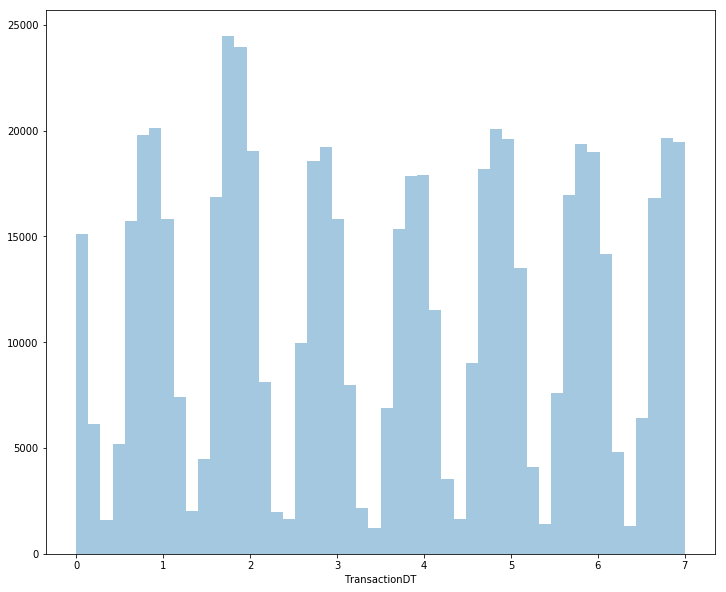

In [20]:
plt.figure(figsize=(12,10))
sns.distplot(days_of_week, kde=False)
plt.show()

In [21]:
encoded_days_of_week = np.round(days_of_week)

In [22]:
encoded_days_of_week

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
5         1.0
6         1.0
7         1.0
8         1.0
9         1.0
10        1.0
11        1.0
12        1.0
13        1.0
14        1.0
15        1.0
16        1.0
17        1.0
18        1.0
19        1.0
20        1.0
21        1.0
22        1.0
23        1.0
24        1.0
25        1.0
26        1.0
27        1.0
28        1.0
29        1.0
30        1.0
31        1.0
32        1.0
33        1.0
34        1.0
35        1.0
36        1.0
37        1.0
38        1.0
39        1.0
40        1.0
41        1.0
42        1.0
43        1.0
44        1.0
45        1.0
46        1.0
47        1.0
48        1.0
49        1.0
         ... 
590490    1.0
590491    1.0
590492    1.0
590493    1.0
590494    1.0
590495    1.0
590496    1.0
590497    1.0
590498    1.0
590499    1.0
590500    1.0
590501    1.0
590502    1.0
590503    1.0
590504    1.0
590505    1.0
590506    1.0
590507    1.0
590508    1.0
590509    1.0
590510

In [23]:
train['TransactionDay'] = encoded_days_of_week

In [24]:
train['TransactionDay'] = train['TransactionDay'].astype('category')

In [26]:
test['TransactionDay'] = np.round(test['TransactionDT'] / (60*60*24) % 7)

In [27]:
test['TransactionDay'] = test['TransactionDay'].astype('category')

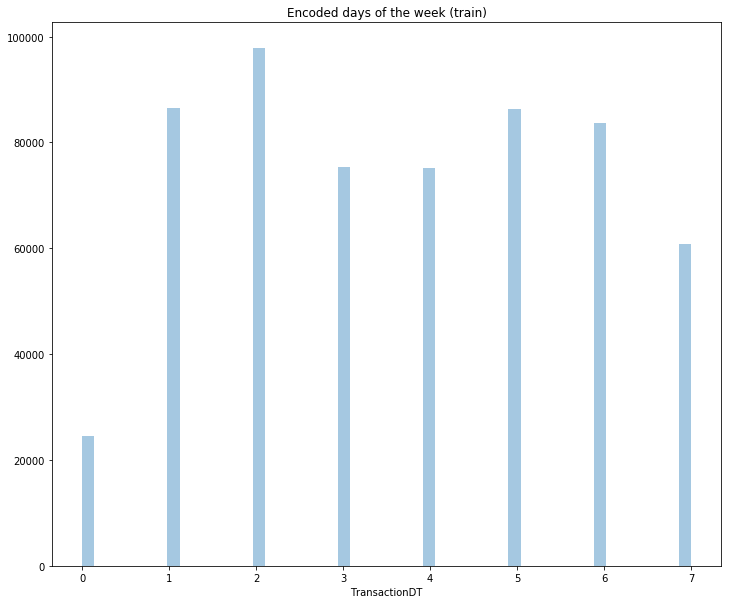

In [28]:
plt.figure(figsize=(12,10))
sns.distplot(encoded_days_of_week, kde=False)
plt.title('Encoded days of the week (train)')
plt.show()

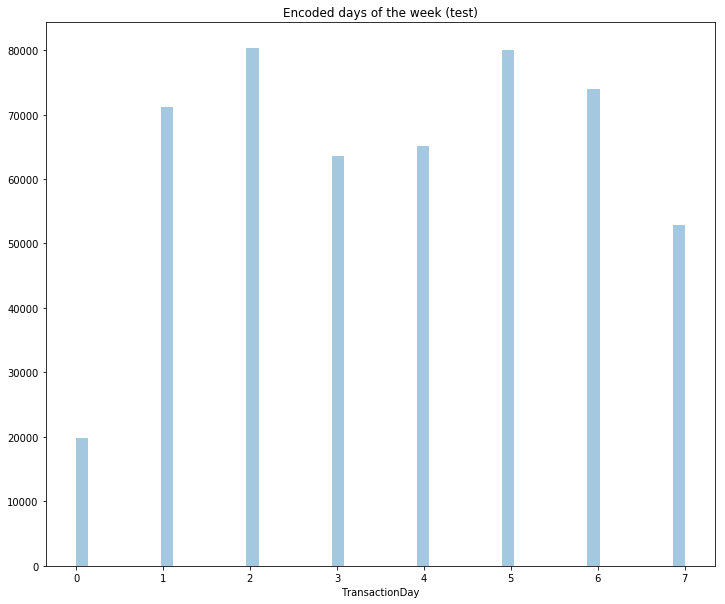

In [29]:
plt.figure(figsize=(12,10))
sns.distplot(test['TransactionDay'], kde=False)
plt.title('Encoded days of the week (test)')
plt.show()

Similar distributions of days in test compared to train. 

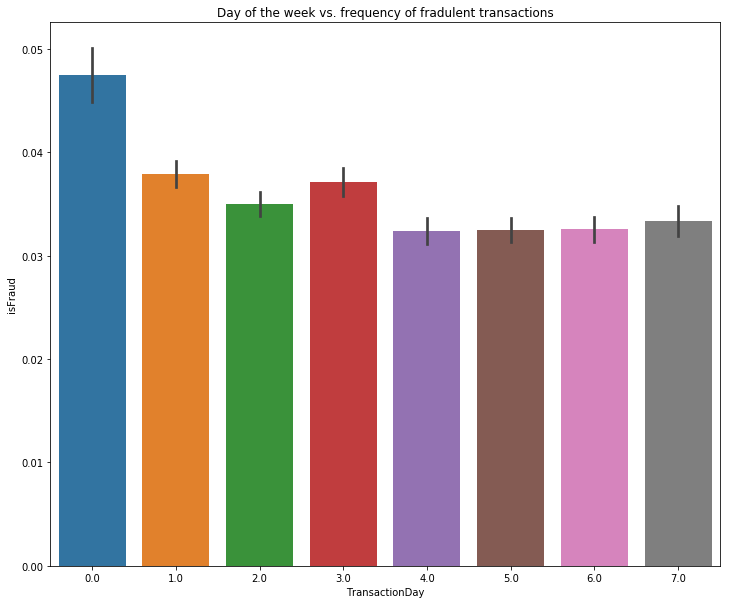

In [30]:
plt.figure(figsize=(12,10))
sns.barplot(x='TransactionDay', y='isFraud', data=train)
plt.title('Day of the week vs. frequency of fradulent transactions')
plt.show()

Looks like day 0 has a stronger association with fraudulent transactions than the others. This could make for a useful feature.

In [31]:
train[train['TransactionDay'] == 0]['isFraud'].value_counts()[1] / train[train['TransactionDay'] == 0]['isFraud'].value_counts()[0]

0.04983360354979094

In [32]:
train[train['TransactionDay'] == 1]['isFraud'].value_counts()[1] / train[train['TransactionDay'] == 1]['isFraud'].value_counts()[0]

0.03938615240519705

In [33]:
train[train['TransactionDay'] == 2]['isFraud'].value_counts()[1] / train[train['TransactionDay'] == 2]['isFraud'].value_counts()[0]

0.036254448398576514

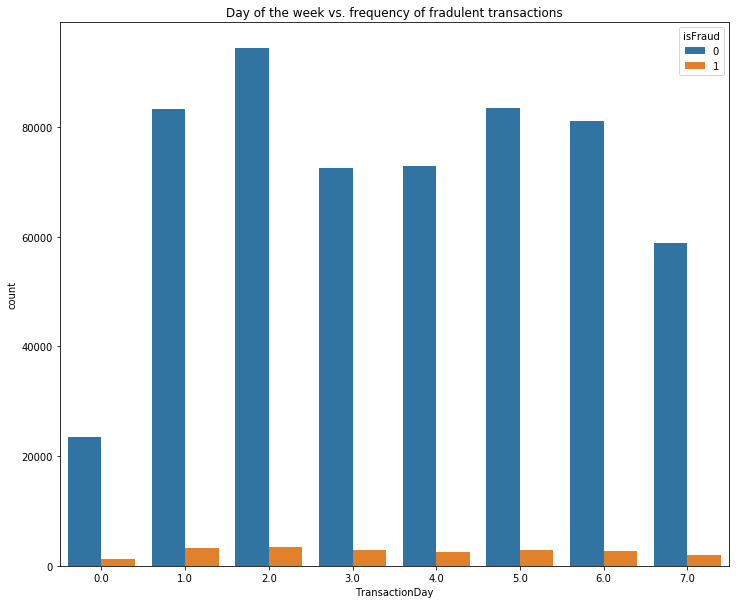

In [34]:
plt.figure(figsize=(12,10))
sns.countplot(x='TransactionDay', hue='isFraud', data=train)
plt.title('Day of the week vs. frequency of fradulent transactions')
plt.show()

# Splitting into train, val, and test

In [35]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train['isFraud']

In [36]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [37]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [38]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [39]:
X_train.shape

(583369, 433)

In [40]:
X_val.shape

(7171, 433)

In [41]:
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)

# Train LightGBM

In [42]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [43]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [44]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=50,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/lgbm/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.994772	valid_1's auc: 0.973784
[100]	training's auc: 0.999414	valid_1's auc: 0.978138
[150]	training's auc: 0.999929	valid_1's auc: 0.980144
[200]	training's auc: 0.999992	valid_1's auc: 0.980077
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.999992	valid_1's auc: 0.980077


# Predict on test sets

In [45]:
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [46]:
sub_preds

array([2.16765404e-05, 2.69005299e-04, 2.50600129e-05, ...,
       1.21493221e-03, 3.15891571e-04, 5.26008613e-05])

In [47]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.980076615865421


# Bootstrapping

In [48]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

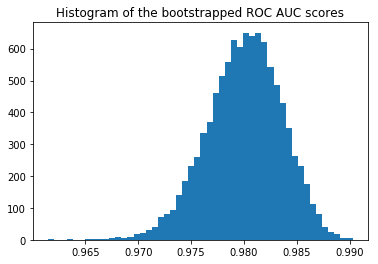

In [49]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [50]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.974 - 0.986]


In [51]:
sorted_scores.mean()

0.9800343467911445

In [52]:
sorted_scores.std()

0.003527097241704787

# Save submission predictions

In [53]:
sub_df['isFraud'] = sub_preds
sub_df.to_csv('../submissions/submission_TransactionDay.csv', index=False)

# Feature importances

In [54]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [55]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [56]:
feature_importance_df.head()

,feature,importance
2,card1,7343
0,TransactionAmt,5303
8,addr1,3570
431,card1_count,2954
10,dist1,2663


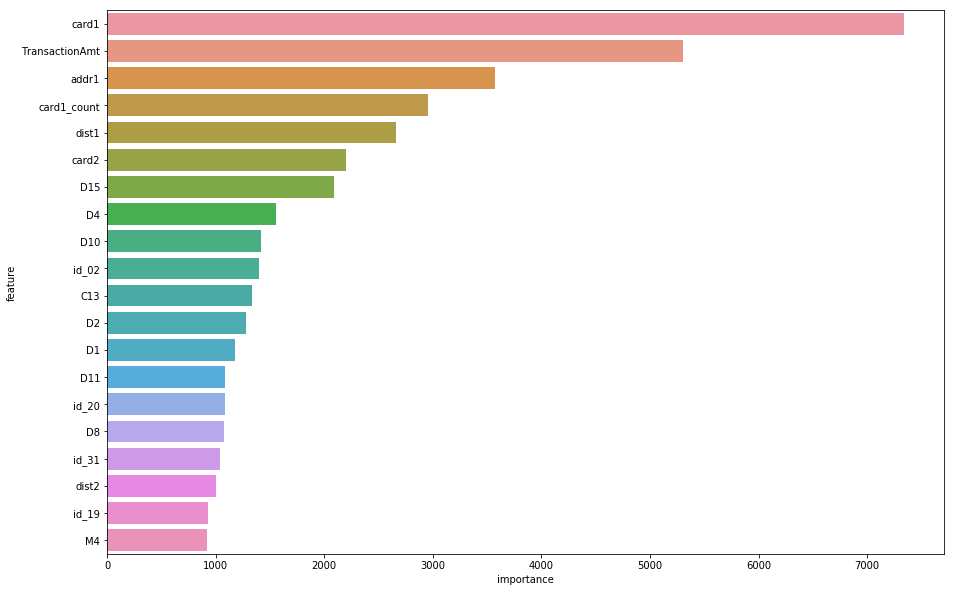

In [57]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

Still not an improvement - proceeding without time features incorporated